# Clustering



In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import matplotlib.pyplot as plt                       
import numpy as np                                   
import pandas as pd                                  
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

from random import sample
import math


import warnings                                       
warnings.filterwarnings('ignore')

In [ ]:
path = '/content/drive/MyDrive/Kaggle/derby/dataset/'

In [ ]:
df = pd.read_csv(path+'nyra_2019_complete.csv')
df.head()

,track_id,race_date,race_number,program_number,trakus_index,latitude,longitude,distance_id,course_type,track_condition,run_up_distance,race_type,purse,post_time,weight_carried,jockey,odds
0,AQU,2019-01-01,9,6,72,40.672902,-73.827607,600,D,GD,48,CLM,25000,420,120,Andre Shivnarine Worrie,2090
1,AQU,2019-01-01,9,6,73,40.672946,-73.827587,600,D,GD,48,CLM,25000,420,120,Andre Shivnarine Worrie,2090
2,AQU,2019-01-01,9,6,74,40.672990,-73.827568,600,D,GD,48,CLM,25000,420,120,Andre Shivnarine Worrie,2090
3,AQU,2019-01-01,9,6,63,40.672510,-73.827781,600,D,GD,48,CLM,25000,420,120,Andre Shivnarine Worrie,2090
4,AQU,2019-01-01,9,6,64,40.672553,-73.827762,600,D,GD,48,CLM,25000,420,120,Andre Shivnarine Worrie,2090


## Preprocessing

Dropping irrelevant columns and duplicated rows: <br/>
'race_date' just doesnt give us any information other than a timestamp, the 'trakus_index','latitude','longitude' and 'distance_id' only gives us information about geographical location of the horse so its also not so helpful.

In [ ]:
df.sample(10)

,track_id,race_date,race_number,program_number,trakus_index,latitude,longitude,distance_id,course_type,track_condition,run_up_distance,race_type,purse,post_time,weight_carried,jockey,odds
2219883,BEL,2019-05-27,7,5,137,40.717588,-73.724629,800,D,FT,52,STK,200000,446,118,Luis Saez,2400
1023590,AQU,2019-04-17,5,6,115,40.674912,-73.827343,600,D,FT,48,CLM,48000,336,120,Irad Ortiz Jr.,55
544667,AQU,2019-12-31,4,6,238,40.673371,-73.831117,650,D,SY,50,CLM,46000,203,122,Dylan Davis,210
2894583,BEL,2019-10-10,2,4,270,40.715658,-73.727350,850,I,FM,45,MCL,41000,149,120,Manuel Franco,65
2098440,AQU,2019-12-14,6,6,173,40.674227,-73.827094,800,D,SY,54,STR,55000,251,123,Junior Alvarado,790
2595662,BEL,2019-10-02,2,5,436,40.713284,-73.720821,900,I,FM,234,MCL,41000,149,120,Jose L. Ortiz,240
2554824,AQU,2019-02-10,5,5,329,40.673045,-73.831247,800,D,FT,54,MCL,46000,300,116,Joey R. Martinez,860
98589,BEL,2019-10-06,4,12,137,40.716947,-73.723449,800,T,FM,76,AOC,70000,225,122,Irad Ortiz Jr.,215
3130949,BEL,2019-07-06,9,5,253,40.716876,-73.724482,1000,I,FM,38,STK,1000000,545,122,Tyler Gaffalione,1660
2041476,AQU,2019-01-05,4,4,135,40.674808,-73.827267,650,D,SY,32,MSW,60000,158,121,Samuel Jimenez,2975


In [ ]:
modeling_data = df.drop(columns=['race_date','trakus_index','latitude','longitude','distance_id'])

In [ ]:
modeling_data.duplicated().sum()

5213349

In [ ]:
modeling_data =modeling_data.drop_duplicates()
modeling_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15081 entries, 0 to 5227892
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   track_id         15081 non-null  object
 1   race_number      15081 non-null  int64 
 2   program_number   15081 non-null  object
 3   course_type      15081 non-null  object
 4   track_condition  15081 non-null  object
 5   run_up_distance  15081 non-null  int64 
 6   race_type        15081 non-null  object
 7   purse            15081 non-null  int64 
 8   post_time        15081 non-null  int64 
 9   weight_carried   15081 non-null  int64 
 10  jockey           15081 non-null  object
 11  odds             15081 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 1.5+ MB


Now after cleaning our data , we have to encode our categorical data to numeric representation.<br/>
Columns to be encoded: 'track_id','program_number', 'course_type', 'track_condition', 'race_type' and 'jockey'. <br/>
(using LabelEncoder)

In [ ]:
len(modeling_data)

15081

In [ ]:
modeling_data_analysis = modeling_data.copy()

In [ ]:
encoded_columns=['track_id','program_number', 'course_type', 'track_condition', 'race_type','jockey']

encodes_dict = {}
for col in encoded_columns:
    le = LabelEncoder()
    modeling_data[col] = modeling_data[col].astype('str') 
    modeling_data[col] = le.fit_transform(modeling_data[col])
    encodes_dict[col] = le.classes_

Data scaling and standardization:<br/>
* MinMaxScaler for categorical data
* StandardScaler for continuous data.

In [ ]:
categorical_columns = ['track_id','race_number','program_number', 'course_type', 'track_condition','race_type','jockey']
continuous_columns = [col for col in modeling_data.columns if col not in categorical_columns]

for col in modeling_data.columns:
    if col in categorical_columns:
        scaler = MinMaxScaler()
        
    elif col in continuous_columns:
        scaler = StandardScaler(with_mean=True , with_std=True)
        
    scaler.fit(modeling_data[col].to_numpy().reshape(-1, 1))
    modeling_data[col] = scaler.transform(modeling_data[col].to_numpy().reshape(-1, 1))

In [ ]:
modeling_data.sample(10)

,track_id,race_number,program_number,course_type,track_condition,run_up_distance,race_type,purse,post_time,weight_carried,jockey,odds
3526025,0.5,0.750000,0.885714,1.00,0.333333,0.626613,1.000000,-0.373417,0.365775,0.153722,0.785311,-0.343734
2387002,0.0,0.416667,0.914286,0.00,0.333333,-0.401470,0.272727,-0.425871,-0.565106,0.436405,0.237288,-0.487177
3688499,0.0,0.250000,0.857143,0.75,0.333333,-0.509690,0.363636,-0.119889,-0.693377,-0.411644,0.435028,-0.415455
2582742,1.0,0.083333,0.914286,1.00,0.000000,-1.213116,0.181818,-0.277251,-1.133164,-0.128961,0.672316,1.751568
4367312,0.5,0.500000,0.742857,1.00,0.000000,1.113601,0.363636,-0.076177,-0.000714,-0.411644,0.785311,0.050736
2644227,0.5,0.583333,0.057143,0.25,0.000000,-0.022703,0.818182,-0.251024,0.109233,-0.694327,0.429379,-0.031231
5037433,0.0,0.166667,0.714286,1.00,0.333333,0.518394,0.727273,0.142382,-0.667723,-0.694327,0.672316,-0.625498
3212750,0.5,0.166667,0.828571,0.00,0.166667,-0.563799,0.000000,-0.058692,-0.026368,-0.128961,0.372881,-0.410332
1536606,1.0,0.500000,0.514286,0.25,0.000000,0.680723,0.090909,-0.006238,0.105568,0.436405,0.598870,1.559456
282806,0.0,0.166667,0.028571,0.00,0.333333,-0.590854,0.000000,-0.119889,-0.631074,0.436405,0.542373,-0.666482


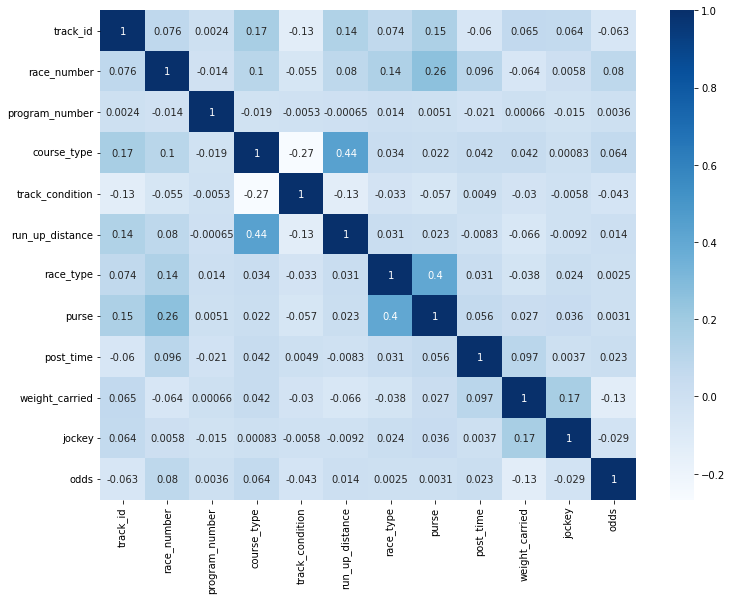

In [ ]:
plt.figure(figsize=(12,9))
sns.heatmap(modeling_data.corr(),cmap='Blues',annot=True)

Attributes that show high degree of coreelation: <br/>
course_type and run_up_distance = 0.43<br/>
purse and race_type = 0.42

The aim is to find any patterns/ understand the racing data more, so k means clustering followed by agglomerative clustering(hierarchial clustering) will be implemented.

K Means Clustering

In [ ]:
clustering_result = pd.DataFrame(modeling_data.index)

In [ ]:
K = range(2,10)
scorelist = []
for k in K:
    kmodel = KMeans(n_clusters=k, random_state=42)
    clust = kmodel.fit_predict(modeling_data)
    clustering_result[f'KMean_{k}'] = clust
    score = silhouette_score(modeling_data,clust,metric='euclidean')
    scorelist.append((k, score)) 
kmeans_res = pd.DataFrame(scorelist, columns=['k','score']) 


In [ ]:
!pip install plotly_express

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import plotly_express as px
fig = px.line(kmeans_res, x='k',y='score')
fig.show()

From the knee-plot, optimal value of k = 6.

Agglomerative Clustering

Agglomerative clustering uses a bottom-up approach, wherein each data point starts in its own cluster. These clusters are then joined greedily, by taking the two most similar clusters together and merging them. Agglomerative clustering does not require pre-defined number of clusters.

In [ ]:
N = range(2,10)
scorelist = []
for n in N:
    kmodel = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
    clust = kmodel.fit_predict(modeling_data)
    clustering_result[f'Agglomerative_{n}'] = clust
    score = silhouette_score(modeling_data,clust,metric='euclidean')
    scorelist.append((n, score)) 
affinity_res = pd.DataFrame(scorelist, columns=['n','score']) 

In [ ]:
px.line(affinity_res, x='n',y='score')

As we can see from the graphs, we got different results for each clustering method. The K means graph is a bit oscilating until 5 while in the Agglomerative graph we got a nice knee shape, therefore we will proceed with this algorithm with N=6 as number of clusters.

In [ ]:
clustering_result['Agglomerative_6'].value_counts()


0    11321
3     1447
2      980
4      904
1      353
5       76
Name: Agglomerative_6, dtype: int64

In [ ]:
modeling_data_analysis['Cluster'] = clustering_result.set_index(modeling_data_analysis.index)['Agglomerative_6'] + 1

In [ ]:
modeling_data['Cluster'] = clustering_result.set_index(modeling_data_analysis.index)['Agglomerative_6'] + 1

In [ ]:
modeling_data_analysis.sample(5)

,track_id,race_number,program_number,course_type,track_condition,run_up_distance,race_type,purse,post_time,weight_carried,jockey,odds,Cluster
2434336,SAR,9,2,T,FM,36,STK,1000000,600,122,Manuel Franco,520,2
884108,SAR,3,4,T,YL,126,AOC,95000,212,126,Joel Rosario,220,4
3471101,BEL,2,5,T,GD,50,MSW,80000,202,118,Kendrick Carmouche,1000,1
1811218,SAR,9,4,D,FT,45,STK,350000,547,118,Irad Ortiz Jr.,340,1
5099240,SAR,6,1,T,FM,130,STR,60000,404,125,Ricardo Santana Jr.,1220,4


In [ ]:
# fig = plt.figure()
# ax = fig.add_subplot(111)

# scatter = ax.scatter(modeling_data.course_type, modeling_data.odds, c=modeling_data_analysis.Cluster, s=50)
# for i, j in centers:
#    ax.scatter(i, j, s=50, c='red', marker='+')

# plt.show()

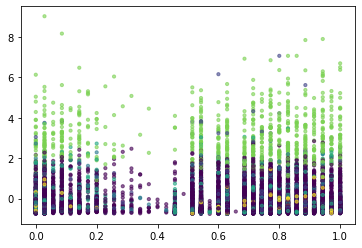

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(modeling_data.program_number, modeling_data.odds, c=modeling_data_analysis.Cluster, alpha = 0.6, s=10)

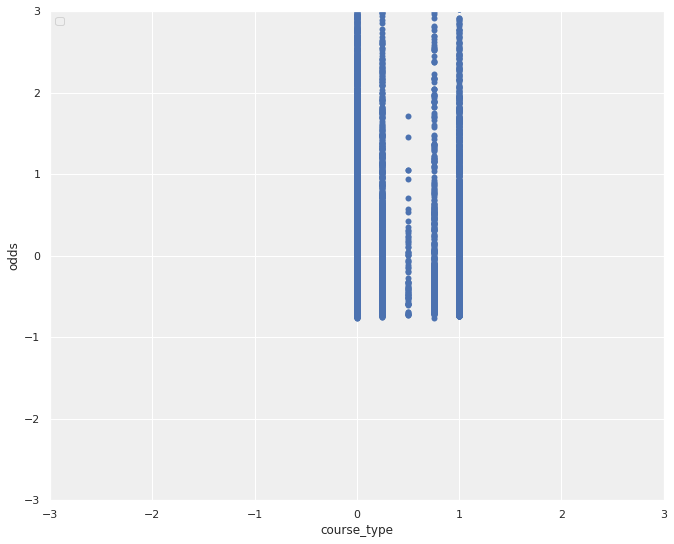

In [ ]:
sns.set(rc={'axes.facecolor':'EFEFEF'})
ax = plt.figure(figsize=(11,9))
ax = sns.scatterplot(data=modeling_data, x = 'course_type', y ='odds',
                     s=36, linewidth=0)
plt.legend(loc='upper left')
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
plt.savefig('scatter.png')
plt.show()

In [ ]:
import plotly.graph_objs as go
Scene = dict(xaxis = dict(title  = 'program_number'),yaxis = dict(title  = 'race_type'),zaxis = dict(title  = 'odds'))

# model.labels_ is nothing but the predicted clusters i.e y_clusters
labels = modeling_data_analysis.Cluster
trace = go.Scatter3d(x=modeling_data_analysis['program_number'], y=modeling_data_analysis['race_type'], z=modeling_data_analysis['odds'], mode='markers',marker=dict(color = labels, size= 10, line=dict(color= 'black',width = 10)))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene,height = 800,width = 800)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

In [ ]:
from scipy.stats import pearsonr
# calculate Pearson's correlation
corr, _ = pearsonr(modeling_data_analysis['odds'], modeling_data_analysis['Cluster'])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.501


In [ ]:
from plotly.subplots import make_subplots


In [ ]:
def categorical_columns_plotter(data,col):
    specs = [[{'type':'domain'}, {'type':'domain'} ,{'type':'domain'}] , [{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]]
    fig = make_subplots(rows=2, cols=3, specs=specs , subplot_titles=['Cluster 1', 'Cluster 2','Cluster 3','Cluster 4','Cluster 5','Cluster 6'])


    for i in range(1,7):
        pos = [(1,1),(1,2),(1,3),(2,1),(2,2),(2,3)]
        fig_data = data.query(f'Cluster == {i}')[col].value_counts(normalize=True)
        fig.add_trace(go.Pie(labels = fig_data.index , values = fig_data, name= f'Cluster {i}'), pos[i-1][0] , pos[i-1][1])

    fig.update_traces(hoverinfo='label+percent+name', textinfo='none')
    fig.update(layout_title_text=f'Clusters {col} distribution',
               layout_showlegend=False)

    fig = go.Figure(fig)
    return fig.show()

In [ ]:
categorical_columns=['race_type','course_type','weight_carried','track_condition']
for col in categorical_columns:
    categorical_columns_plotter(modeling_data_analysis,col)

In [ ]:
modeling_data

,track_id,race_number,program_number,course_type,track_condition,run_up_distance,race_type,purse,post_time,weight_carried,jockey,odds,Cluster
0,0.0,0.666667,0.828571,0.00,0.333333,-0.509690,0.181818,-0.513295,0.028605,-0.128961,0.028249,0.312009,1
297,0.0,0.500000,0.542857,0.75,0.000000,-0.239141,0.181818,-0.189828,0.109233,-0.128961,0.672316,-0.587075,1
572,0.5,0.750000,1.000000,0.25,0.000000,0.626613,0.090909,0.011247,0.776242,0.153722,0.237288,0.534859,1
845,0.5,0.416667,0.828571,0.25,0.000000,1.221820,0.181818,-0.207312,-0.000714,0.719089,0.672316,-0.092707,1
1125,1.0,0.166667,0.828571,1.00,0.333333,0.193736,0.181818,-0.277251,-0.741021,0.436405,0.372881,-0.138814,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226195,0.0,0.250000,0.600000,0.75,1.000000,-0.293251,0.727273,0.360942,-1.133164,-0.128961,0.435028,-0.471808,1
5226482,0.5,0.500000,0.971429,0.25,1.000000,1.600588,0.727273,0.142382,0.732263,-0.128961,0.672316,-0.251520,4
5226784,0.5,0.750000,0.742857,1.00,0.333333,-0.103867,0.727273,8.010512,0.494046,0.436405,0.299435,0.219795,2
5227338,0.5,0.750000,0.685714,1.00,0.333333,-0.103867,0.727273,8.010512,0.494046,0.436405,0.920904,1.200847,2


In [ ]:
#########START OF NEW
X = modeling_data[modeling_data.columns[:-1]].values
y = modeling_data[modeling_data.columns[-1]].values

#Performed PCA on the modeling_dataset  -
Principal component analysis, or PCA, is a dimensionality-reduction method that is often used to reduce the dimensionality of large data sets, by transforming a large set of variables into a smaller one that still contains most of the information in the large set.<br/>
Smaller data sets are easier to explore and visualize and make analyzing data much easier and faster for machine learning algorithms without extraneous variables to process.


In [ ]:
from sklearn import decomposition 
pca = decomposition.PCA(0.90)
print("Shape of X before PCA -", X.shape)
X = pca.fit_transform(X)
print("Shape of X after PCA -", X.shape)

Shape of X before PCA - (15081, 12)
Shape of X after PCA - (15081, 5)


Exactly 5 features explain 90% of the variance in the dataset.

In [ ]:
fig = px.scatter(
                   x=X[:,0],
                   y=X[:,1],
                   template='simple_white',
                   color_discrete_sequence=px.colors.qualitative.G10,
                   title='PCA Scatterplot'
                 )

fig.update_layout(xaxis_title="PC1 ",yaxis_title="PC2")

fig.show()

In [ ]:
from imblearn.over_sampling  import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')
X, y = oversample.fit_resample(X, y)

In [ ]:
print('X Shape -', X.shape)
print('y Shape -',y.shape)


X Shape - (26326, 5)
y Shape - (26326,)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
print(X_train.shape[0], 'rows for training.')
print(X_test.shape[0], 'rows for validation.')

19744 rows for training.
6582 rows for validation.


In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
names = ["KNN", "Linear_SVM", "XGBClassifier", "Random Forest"]
classifiers = [
    KNeighborsClassifier(n_neighbors=3),
    SVC(kernel="linear", C=0.025),
    XGBClassifier(objective='binary:hinge'),
    RandomForestClassifier(max_depth=5, n_estimators=100)]

modelscores = []
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    modelscores.append(score)
    
scores_df = pd.DataFrame()
scores_df['name'] = names
scores_df['score'] = modelscores
scores_df.sort_values('score', ascending= False)

,name,score
0,KNN,0.993163
2,XGBClassifier,0.989213
1,Linear_SVM,0.988453
3,Random Forest,0.978122


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score,precision_score,f1_score

In [ ]:
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(name, "Precision - ",precision_score(y_test, y_pred, average='weighted'))
    print(name, "Recall - ",recall_score(y_test,y_pred, average='weighted'))
    print(name, "F1 score - ",f1_score(y_test,y_pred, average='weighted'))

KNN Precision -  0.9931194518050823
KNN Recall -  0.9931631722880584
KNN F1 score -  0.9931314408329192
Linear_SVM Precision -  0.9883238086639741
Linear_SVM Recall -  0.9884533576420541
Linear_SVM F1 score -  0.9883581780269206
XGBClassifier Precision -  0.9891366089891885
XGBClassifier Recall -  0.9892130051656032
XGBClassifier F1 score -  0.9891213997882499
Random Forest Precision -  0.9767781688921267
Random Forest Recall -  0.9769067152841082
Random Forest F1 score -  0.9759382420467451


In [ ]:
confusionmatrix = np.around(confusion_matrix(y_test, y_pred, normalize='true'),2)

fig = px.imshow(confusionmatrix, 
                text_auto=True, 
                color_continuous_scale=px.colors.sequential.Viridis, 
                aspect="auto", 
                labels=dict(x="Predicted Label", y="Correct Label"))

fig.update_xaxes(side="top")
plt.figure(figsize=(9,7))
fig.show()

<Figure size 648x504 with 0 Axes>

In [ ]:
###END of NEW

In [ ]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

regr = LinearRegression()
regr.fit(X_train, y_train)
print(regr.score(X_test, y_test))
y_pred = regr.predict(X_test)
y_pred
# plt.scatter(X_test.iloc[:], y_test, color ='b')
print(y_pred-y_test)
# plt.plot(y_test, y_pred, color ='k')
# plt.show()

0.8677211102101701
[-0.06079534 -1.77969165 -0.09144215 ... -2.15256908 -0.11347036
 -0.1251372 ]
